# THỰC HÀNH MODEL SELECTION

## Bài toán

- Cần đánh giá hiệu quả của một mô hình phân loại?
- So sánh hiệu quả của 2 mô hình khác nhau?

Nhưng ta chỉ có một tập dữ liệu đã thu thập được. Để trả lời hai câu hỏi trên thì cần thực hiện
bước “Lựa chọn tham số” của mô hình đã chọn.

Bài này sẽ hướng dẫn cách thực hiện từng bước chi tiết, từ lựa chọn tham số (sử dụng Cross
validation), cho đến đánh giá (sử dụng Holdout) và so sánh hai mô hình khác nhau. Tập dữ liệu
sử dụng là tập văn bản đã thu thập được ở Bài học số 2 (tập tin tức từ Vnexpress)

## Các bước cần thực hiện

- Load dữ liệu từ thư mục
- Tiền xử lý dữ liệu
- Lựa chọn tham số các mô hình
- So sánh SVM và Random Forest

## Bước 1 - Cài đặt thư viện

In [1]:
!pip install pyvi

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from tqdm import tqdm
from sklearn.datasets import load_files
from pyvi import ViTokenizer

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

## Bước 2 - Load dữ liệu từ thư mục

Giả sử cấu trúc thư mục như sau:

• data/news_vnexpress/
- Kinh tế
   - bài báo 1.txt
   - bài báo 2.txt
- Pháp luật
   - bài báo 3.txt
   - bài báo 4.txt

In [9]:
INPUT = '../data/news_1135/'
# thư mục lưu các hình ảnh kết quả trong quá trình huấn luyện và đánh giá
os.makedirs("images", exist_ok=True) 

### 2.1. Tìm hiểu dữ liệu

In [11]:
import os
print(os.getcwd())

d:\Program Files\VSCode\ML_practice\week3


In [12]:
# statistics
print('Các nhãn và số văn bản tương ứng trong dữ liệu')
print('----------------------------------------------')
n = 0
for label in os.listdir(INPUT):
    label_path = os.path.join(INPUT, label)
    # Skip if not a directory or if name contains 'stop'
    if not os.path.isdir(label_path) or 'stop' in label:
        continue
    print(f'{label}: {len(os.listdir(label_path))}')
    n += len(os.listdir(label_path))

print('-------------------------')
print(f"Tổng số văn bản: {n}")

Các nhãn và số văn bản tương ứng trong dữ liệu
----------------------------------------------
Giải trí: 107
Khoa học - Công nghệ: 196
Kinh tế: 186
Pháp luật: 50
Sức khỏe: 75
Thể thao: 140
Thời sự: 138
Tin khác: 100
Độc giả: 52
Đời sống - Xã hội: 91
-------------------------
Tổng số văn bản: 1135


### 2.2. Load dữ liệu

In [13]:
# load data
data_train = load_files(container_path=INPUT, encoding="utf-8")
print('mapping:')

for i in range(len(data_train.target_names)):
    print(f'{data_train.target_names[i]} - {i}')

print('--------------------------')
print(data_train.filenames[0:1])
# print(data_train.data[0:1])
print(data_train.target[0:1])
print(data_train.data[0:1])
print("\nTổng số văn bản: {}" .format( len(data_train.filenames)))

mapping:
Giải trí - 0
Khoa học - Công nghệ - 1
Kinh tế - 2
Pháp luật - 3
Sức khỏe - 4
Thể thao - 5
Thời sự - 6
Tin khác - 7
Độc giả - 8
Đời sống - Xã hội - 9
--------------------------
['../data/news_1135/Tin khác\\0218e1df21ce358b9c6485176a48f1fcaeedef67.txt']
[7]
['Dân_trí Sở GD & ĐT tỉnh Gia_Lai vừa ra văn_bản số 2258 / SGDĐT - VP , về việc chấn_chỉnh việc tiếp_thị sách và các vật_dụng khác trong các cơ_sở giáo_dục . Văn_bản chỉ_đạo , tuyệt_đối không cho phép các cá_nhân , tập_thể đến trường tiếp_thị , quảng_cáo mua_bán sách , dụng_cụ học_tập … cho giáo_viên và học_sinh trong nhà_trường . Các tổ_chức , cá_nhân trong ngành giáo_dục tuyệt_đối không được thực_hiện hoặc tham_gia giới_thiệu , quảng_bá , vận_động mua , phát_hành sách tham_khảo tới học_sinh hoặc phụ_huynh dưới hình_thức nào . Nhà_trường tuyệt_đối không được lưu_hành , sử_dụng sách có nội_dung không lành_mạnh , không phù_hợp với nội_dung chương_trình phổ_thông . Trường_hợp phát_hiện sách có sai_sót , các đơn_vị cần báo_cáo 

## Bước 3 - Tiền xử lý dữ liệu

### 3.1. Chuyển dữ liệu về dạng số

In [15]:
# load dữ liệu các stopwords
with open("../data/vietnamese-stopwords.txt", encoding="utf-8") as f:
    stopwords = f.readlines()

stopwords = [x.strip().replace(" ", "_") for x in stopwords]
print(f"Số lượng stopwords: {len(stopwords)}")
print(stopwords[:10])
# Chuyển hoá dữ liệu text về dạng vector sử dụng bag-of-words và tf-idf
#- loại bỏ từ dừng
#- sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([
    ('vect', module_count_vector),
    ('tf', TfidfTransformer()),
])
# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array
data_preprocessed = model_rf_preprocess.fit_transform(
    data_train.data, data_train.target
)

print(f"\nSố lượng từ trong từ điển: {len(module_count_vector.vocabulary_)}")
print(f"Kích thước dữ liệu sau khi xử lý: {data_preprocessed.shape}")
print(f"Kích thước nhãn tương ứng: {data_train.target.shape}")

Số lượng stopwords: 2063
['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']

Số lượng từ trong từ điển: 24389
Kích thước dữ liệu sau khi xử lý: (1135, 24389)
Kích thước nhãn tương ứng: (1135,)


### 3.2. Chia dữ liệu thành tập train và tập test

In [16]:
p = 0.2
pivot = int(data_preprocessed.shape[0] * (1-0.2))
X_train, X_test = data_preprocessed[0:pivot], data_preprocessed[pivot:]
Y_train, Y_test = data_train.target[0:pivot], data_train.target[pivot:]

## Bước 4 - Tối ưu tham số

Chỉ dùng tập train để thực hiện lựa chọn tham số.- SVM: kernel, C- Random Forest: criteria, N

Ta sẽ dùng chiến lược Cross Validation trong bước này.

In [17]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(
        estimator, X_train, Y_train, cv=5, n_jobs=-1, train_sizes=[1.0, ], scoring="accuracy"
    )
    
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

### 4.1. Đánh giá độ hiệu quả của các Kernel trong SVM

100%|██████████| 4/4 [00:17<00:00,  4.49s/it]


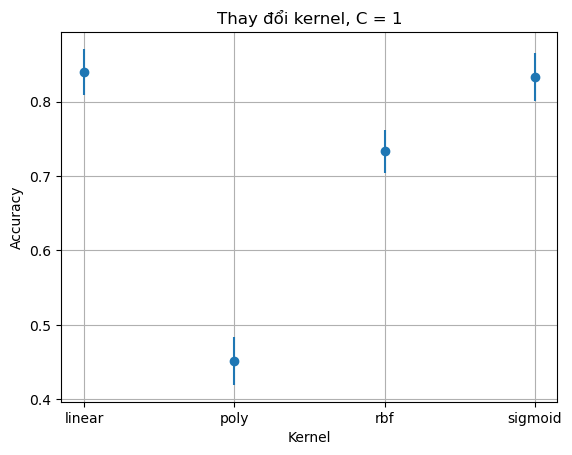

In [18]:
title = "Thay đổi kernel, C = 1"
xlabel = "Kernel"
X = []
Y = []
error = []
# lưu kết quả ra file ảnh
for kernel in tqdm(['linear', 'poly', 'rbf', 'sigmoid']):
    # Với mỗi kernel được chọn,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = svm.SVC(kernel=kernel, C=1.0)
    mean, std = cross_validation(text_clf)
    X.append(kernel)
    Y.append(mean)
    error.append(std)
plot(title, xlabel, X, Y, error)
plt.savefig('images/svm_change_kernel.png', bbox_inches='tight')
plt.show()

### 4.2. Đánh giá ảnh hưởng của độ đo trong RF

100%|██████████| 2/2 [00:06<00:00,  3.19s/it]


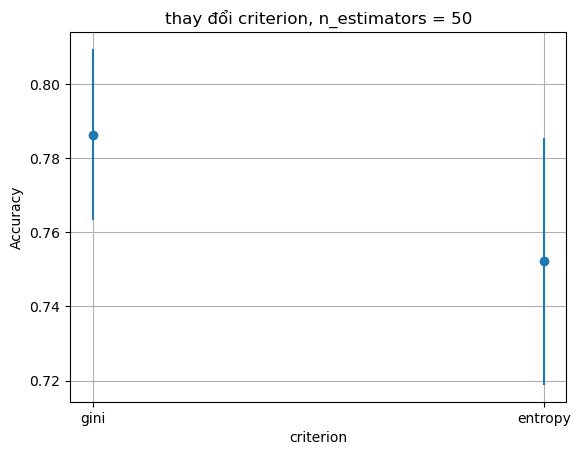

In [19]:
title = "thay đổi criterion, n_estimators = 50"
xlabel = "criterion"
X = []
Y = []
error = []
# lưu kết quả ra file ảnh
for criterion in tqdm(["gini", "entropy"]):
# Với mỗi criterion nhận được,
# thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion=criterion, n_estimators=50)
    mean, std = cross_validation(text_clf)
    X.append(str(criterion))
    Y.append(mean)
    error.append(std)
    
plot(title, xlabel, X, Y, error)
plt.savefig('images/RF_change_criterion.png', bbox_inches='tight')
plt.show()

### 4.4. Đánh giá ảnh hưởng của số cây trong RF

100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


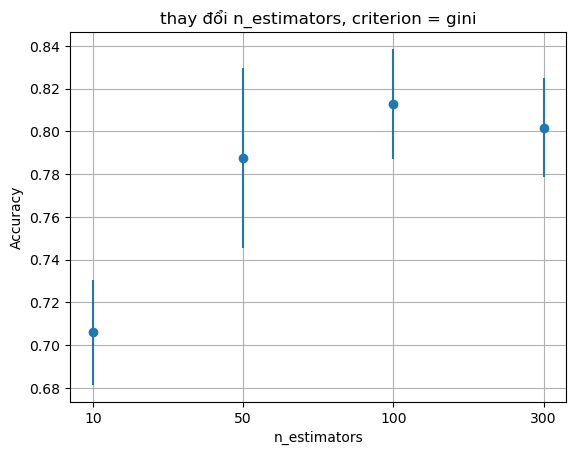

In [20]:
title = "thay đổi n_estimators, criterion = gini"
xlabel = "n_estimators"
X = []
Y = []
error = []
for n_estimators in tqdm([10, 50, 100, 300]):
# Với từng giá trị n_estimators nhận được,
# thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion='gini', n_estimators=n_estimators)
    mean, std = cross_validation(text_clf)
    X.append(str(n_estimators))
    Y.append(mean)
    error.append(std)
# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/RF_change_N.png', bbox_inches='tight')
plt.show()

### 4.5. Đánh giá ảnh hưởng của tham số K trong mô hình KNN

100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


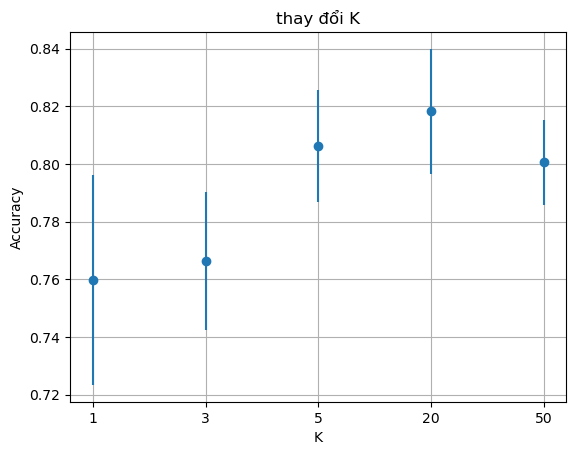

In [21]:
from sklearn.neighbors import KNeighborsClassifier

title = "thay đổi K"
xlabel = "K"
X = []
Y = []
error = []
# lưu kết quả ra file ảnh
for k in tqdm([1, 3, 5, 20, 50]):
    # Với từng giá trị k nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = KNeighborsClassifier(n_neighbors=k)
    mean, std = cross_validation(text_clf)
    X.append(str(k))
    Y.append(mean)
    error.append(std)
plot(title, xlabel, X, Y, error)
plt.savefig('images/KNN_change_K.png', bbox_inches='tight')
plt.show()

## Bước 5 - So sánh các mô hình

- Sau khi chọn được các bộ tham số tốt nhất cho mỗi mô hình, ta huấn luyện lại trên toàn bộ
tập Train.
- Dùng các mô hình mới huấn luyện để phán đoán cho các dữ liệu trong tập Test
- Đo đạc Độ chính xác (Accuracy) của chúng và so sánh kết quả.

In [22]:
svm_ = svm.SVC(kernel='linear', C=1.0)
rf = RandomForestClassifier(criterion='gini', n_estimators=300)
knn = KNeighborsClassifier(n_neighbors=5)
# Huấn luyện các mô hình trên tập dữ liệu train đầy đủ
svm_.fit(X_train, Y_train)
rf.fit(X_train, Y_train)
knn.fit(X_train, Y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


### 5.1. Kết quả dự đoán trên tập Test

In [23]:
# Kết quả dự đoán trên tập test
print(f'SVM: {accuracy_score(Y_test, svm_.predict(X_test))}')
print(f'RF: {accuracy_score(Y_test, rf.predict(X_test))}')
print(f'KNN: {accuracy_score(Y_test, knn.predict(X_test))}')

SVM: 0.8678414096916299
RF: 0.8237885462555066
KNN: 0.8546255506607929


### 5.2. Vẽ confusion matrix của cả 3 mô hình (SVM, KNN, RF)

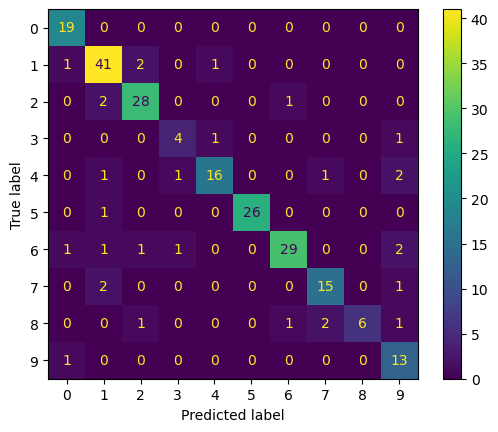

In [25]:
Y_pred_svm = svm_.predict(X_test)
cm_svm = confusion_matrix(Y_test, Y_pred_svm, labels=svm_.classes_)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_.classes_)
disp_svm.plot()
plt.show()

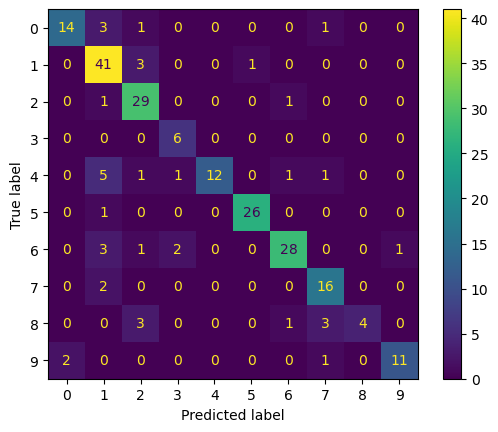

In [26]:
Y_pred_rf = rf.predict(X_test)
cm_rf = confusion_matrix(Y_test, Y_pred_rf, labels=rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
disp_rf.plot()
plt.show()

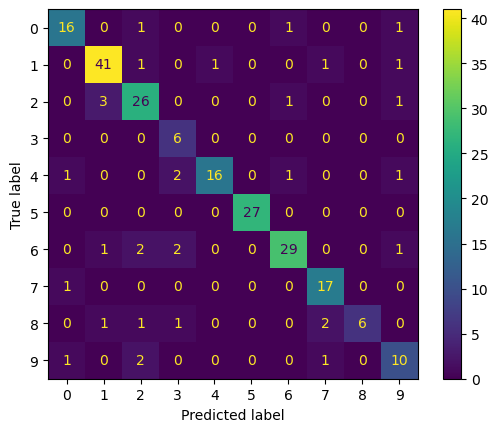

In [30]:
Y_pred_knn = knn.predict(X_test)
cm_knn = confusion_matrix(Y_test, Y_pred_knn, labels=knn.classes_)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn.classes_)
disp_knn.plot()
plt.show()